In [2]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
import xarray as xr

In [17]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [18]:
def zero_sum_gauge(J_ij):
    J_ij_0 = (J_ij
              - np.mean(J_ij, axis=2)[:, :, np.newaxis, :]
              - np.mean(J_ij, axis=3)[:, :, :, np.newaxis]
              + np.mean(J_ij, axis=(2,3))[:, :, np.newaxis, np.newaxis])
    for i in range(Jij.shape[0]):
        J_ij_0[i, i] = np.nan
    return J_ij_0

In [24]:
Jij0 = zero_sum_gauge(Jij)

In [25]:
L = hi.shape[0]
Jij_xr = xr.DataArray(Jij0,
             dims=("i", "j", 'alpha', 'beta'),
             coords={'i': range(L),
                     'j': range(L),
                     'alpha': list(aminoacids),
                     'beta':list(aminoacids)
                    })
Jij_df = Jij_xr.to_dataframe('Jij').loc[0,:].reset_index()
Jij_df.dropna(inplace=True)
Jij_df.sort_values('Jij').head(n=10)

,j,alpha,beta,Jij
522,1,H,D,-0.357495
772,1,W,P,-0.331878
647,1,P,I,-0.313556
523,1,H,E,-0.306892
520,1,H,A,-0.297983
545,1,I,G,-0.274510
475,1,E,S,-0.268095
664,1,Q,F,-0.249717
483,1,F,E,-0.244680
675,1,Q,S,-0.243156


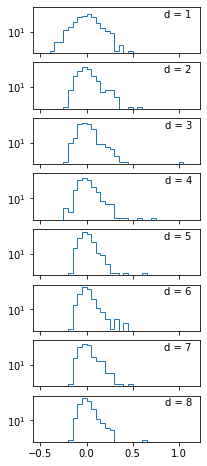

In [20]:
fig, axes = plt.subplots(figsize=(3, 8), sharex=True, sharey=True, nrows=L-1)
for j in range(1, L):
    ax = axes[j-1]
    ax.hist(Jij_df[Jij_df['j']==j]['Jij'], bins=np.arange(-0.5, 1.2, 0.05), histtype='step')
    ax.text(0.95, 0.95, 'd = %i'%j, transform=ax.transAxes, va='top', ha='right')
for ax in axes:
    ax.set_yscale('log')

In [26]:
mean_Jij = Jij0[0, 1:].mean(axis=0)

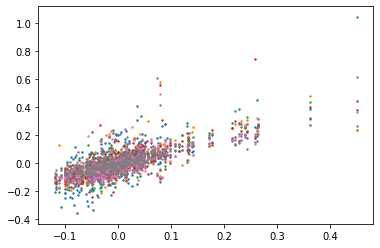

In [31]:
for j in range(1, 9):
    plt.scatter(mean_Jij, Jij0[0, j], s=2)

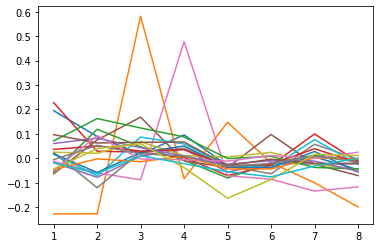

In [32]:
dist = np.arange(1, 9)
for i in range(naminoacids):
    plt.plot(dist, Jij0[0, dist][:,i,i]-np.mean(Jij[0, dist][:,i,i]))

In [33]:
symmetrized = np.zeros_like(mean_Jij)
for i in range(naminoacids):
    for j in range(naminoacids):
        symmetrized[i, j] = 0.5*(mean_Jij[i, j] + mean_Jij[j, i])

In [34]:
def label(ax, aminoacidorder):
    ax.set_xticks(range(naminoacids))
    ax.set_yticks(range(naminoacids))
    ax.set_xticklabels(list(aminoacidorder))
    ax.set_yticklabels(list(aminoacidorder))

In [35]:
aminoacids_coucke = 'ACFILMVWYPHKRDENQSTG'

In [36]:
indices = [aminoacids.index(aa) for aa in aminoacids_coucke]

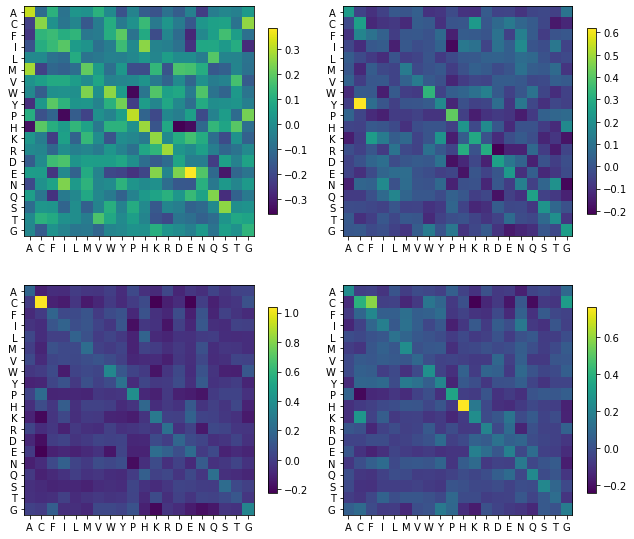

In [44]:
imshow_kwargs = dict(vmin=mean_Jij.min(), vmax=mean_Jij.max())
fig, axes_arr = plt.subplots(figsize=(9, 8), nrows=2, ncols=2)
axes = axes_arr.flatten()
for j in range(1, 5):
    ax = axes[j-1]
    im = ax.imshow(Jij[0,j][indices, :][:, indices])
    label(ax, aminoacids_coucke)
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

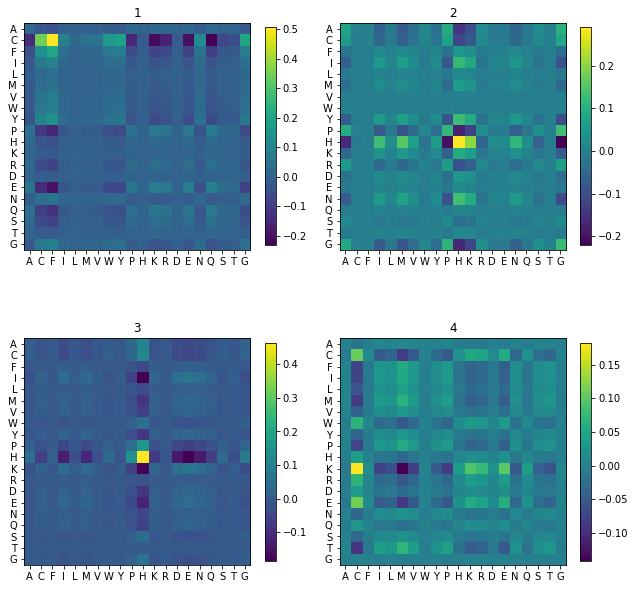

In [38]:
fig, axes_arr = plt.subplots(figsize=(9, 9), nrows=2, ncols=2)
axes = axes_arr.flatten()
U, s, Vh = scipy.linalg.svd(Jij[0, 4])
for i in range(4):
    im = axes[i].imshow((s[i]*np.outer(U.T[i], Vh[i]))[indices, :][:, indices])
    axes[i].set_title(i+1)
    label(axes[i], aminoacids_coucke)
    fig.colorbar(im, ax=axes[i], shrink=0.7)
fig.tight_layout()

In [186]:
w, v = scipy.linalg.eigh(symmetrized)

(array([0., 1., 1., 0., 4., 2., 3., 1., 3., 0., 0., 2., 0., 1., 0., 0., 0.,
        0., 1., 1., 0.]),
 array([-2.00000000e-01, -1.50000000e-01, -1.00000000e-01, -5.00000000e-02,
        -5.55111512e-17,  5.00000000e-02,  1.00000000e-01,  1.50000000e-01,
         2.00000000e-01,  2.50000000e-01,  3.00000000e-01,  3.50000000e-01,
         4.00000000e-01,  4.50000000e-01,  5.00000000e-01,  5.50000000e-01,
         6.00000000e-01,  6.50000000e-01,  7.00000000e-01,  7.50000000e-01,
         8.00000000e-01,  8.50000000e-01]),
 <a list of 21 Patch objects>)

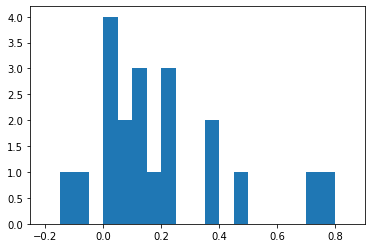

In [197]:
plt.hist(w, bins=np.arange(-0.2, 0.9, 0.05))

In [3]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']

In [6]:
cov = np.cov(aa_human.T)

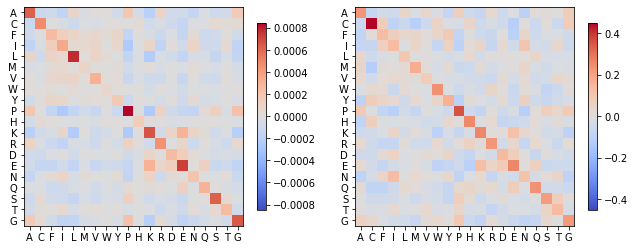

In [51]:
fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
for i, matrix in enumerate([cov, mean_Jij]):
    ax = axes[i]
    im = ax.imshow(matrix[indices, :][:, indices], vmin=-matrix.max(), vmax=matrix.max(), cmap='coolwarm')
    label(ax, aminoacids_coucke)
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()